In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import re
from time import sleep  # optional: to be nice to the API

In [2]:
# ----- Run for a specific author -----
author_id = "R.Suzuki.2"

In [3]:
# --- GET AUTHOR'S PAPERS ---
def fetch_author_recids(author_id):
    base_url = "https://inspirehep.net/api/literature"
    params = {
        "q": f"a {author_id}",
        "size": 1000,
        "fields": "control_number"
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    data = response.json()
    recids = []
    for hit in data.get("hits", {}).get("hits", []):
        recid = hit.get("metadata", {}).get("control_number")
        if recid:
            recids.append(recid)
    return recids

In [4]:
# --- fetch paper IDs ---
recids = fetch_author_recids(author_id)
print(f"Found {len(recids)} papers. Getting citations...")

Found 27 papers. Getting citations...


In [5]:
# --- GET CITING DATES FOR A SINGLE PAPER ---
def get_citing_dates(recid):
    all_dates = []
    url    = "https://inspirehep.net/api/literature"
    params = {
        "q":    f"refersto:recid:{recid}",  
        "size": 250,                        
        "sort": "mostrecent"                
    }

    while url:
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        data = resp.json()
        raw  = resp.text

        # 1) full dates: YYYY-MM-DD
        for d in re.findall(r'"earliest_date":"(\d{4}-\d{2}-\d{2})"', raw):
            all_dates.append(datetime.strptime(d, "%Y-%m-%d"))

        # 2) year‑month only: YYYY-MM  (but not YYYY-MM-DD -> Day = 01)
        for ym in re.findall(r'"earliest_date":"(\d{4}-\d{2})"(?!-)', raw):
            all_dates.append(datetime.strptime(f"{ym}-01", "%Y-%m-%d"))

        # 3) year only: YYYY (but not YYYY- or YYYY-MM -> Month,Day = July,01)
        for y in re.findall(r'"earliest_date":"(\d{4})"(?![-\d])', raw):
            all_dates.append(datetime.strptime(f"{y}-07-01", "%Y-%m-%d"))

        # follow pagination
        url    = data.get("links", {}).get("next")
        params = {}  # next links already include all query parameters

    return sorted(all_dates)

In [6]:
get_citing_dates(836695)

[datetime.datetime(2009, 12, 1, 0, 0),
 datetime.datetime(2009, 12, 1, 0, 0),
 datetime.datetime(2009, 12, 1, 0, 0),
 datetime.datetime(2009, 12, 1, 0, 0),
 datetime.datetime(2009, 12, 1, 0, 0),
 datetime.datetime(2010, 2, 1, 0, 0),
 datetime.datetime(2010, 2, 1, 0, 0),
 datetime.datetime(2010, 2, 1, 0, 0),
 datetime.datetime(2010, 2, 1, 0, 0),
 datetime.datetime(2010, 2, 1, 0, 0),
 datetime.datetime(2010, 3, 1, 0, 0),
 datetime.datetime(2010, 3, 1, 0, 0),
 datetime.datetime(2010, 3, 1, 0, 0),
 datetime.datetime(2010, 3, 29, 0, 0),
 datetime.datetime(2010, 5, 1, 0, 0),
 datetime.datetime(2010, 6, 1, 0, 0),
 datetime.datetime(2010, 6, 1, 0, 0),
 datetime.datetime(2010, 6, 1, 0, 0),
 datetime.datetime(2010, 7, 1, 0, 0),
 datetime.datetime(2010, 7, 17, 0, 0),
 datetime.datetime(2010, 8, 1, 0, 0),
 datetime.datetime(2010, 8, 1, 0, 0),
 datetime.datetime(2010, 9, 1, 0, 0),
 datetime.datetime(2010, 9, 1, 0, 0),
 datetime.datetime(2010, 10, 1, 0, 0),
 datetime.datetime(2010, 10, 1, 0, 0),
 da

In [7]:
print(len(_))

95


In [8]:
# --- ACCUMULATE AND PLOT CITATIONS ---
def build_citation_df(dates):
    df = pd.DataFrame(dates, columns=["date"])
    df["count"] = 1
    df = df.groupby("date").sum().sort_index()
    df["cumulative"] = df["count"].cumsum()
    return df

def plot_citations(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df.index, df["cumulative"], marker="o")
    ax.set_title("Total Cumulative Citations Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Citations")
    ax.grid(True)

    import matplotlib.dates as mdates
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    return fig

[1/27] Processing recid 1269342
[2/27] Processing recid 1480399
[3/27] Processing recid 1114058
[4/27] Processing recid 845471
[5/27] Processing recid 789929
[6/27] Processing recid 813725
[7/27] Processing recid 822065
[8/27] Processing recid 1225364
[9/27] Processing recid 1410186
[10/27] Processing recid 885815
[11/27] Processing recid 761957
[12/27] Processing recid 836695
[13/27] Processing recid 1089418
[14/27] Processing recid 1699935
[15/27] Processing recid 1518170
[16/27] Processing recid 725314
[17/27] Processing recid 776830
[18/27] Processing recid 799690
[19/27] Processing recid 699333
[20/27] Processing recid 824101
[21/27] Processing recid 1781300
[22/27] Processing recid 2690144
[23/27] Processing recid 1841061
[24/27] Processing recid 2638434
[25/27] Processing recid 2840946
[26/27] Processing recid 2129283
[27/27] Processing recid 1353691


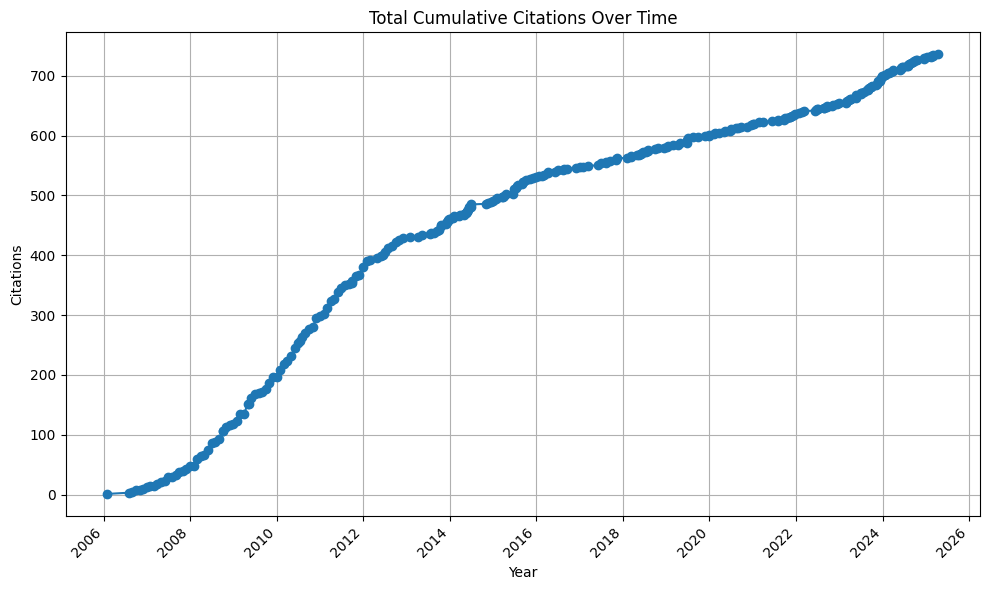

In [9]:
# --- MAIN LOGIC ---

all_dates = []
for i, recid in enumerate(recids, 1):
    print(f"[{i}/{len(recids)}] Processing recid {recid}")
    dates = get_citing_dates(recid)
    all_dates.extend(dates)
    sleep(0.5)  # optional: prevent overwhelming the API

if all_dates:
    df = build_citation_df(all_dates)
    plot_citations(df)
else:
    print("No citation dates found for any paper.")

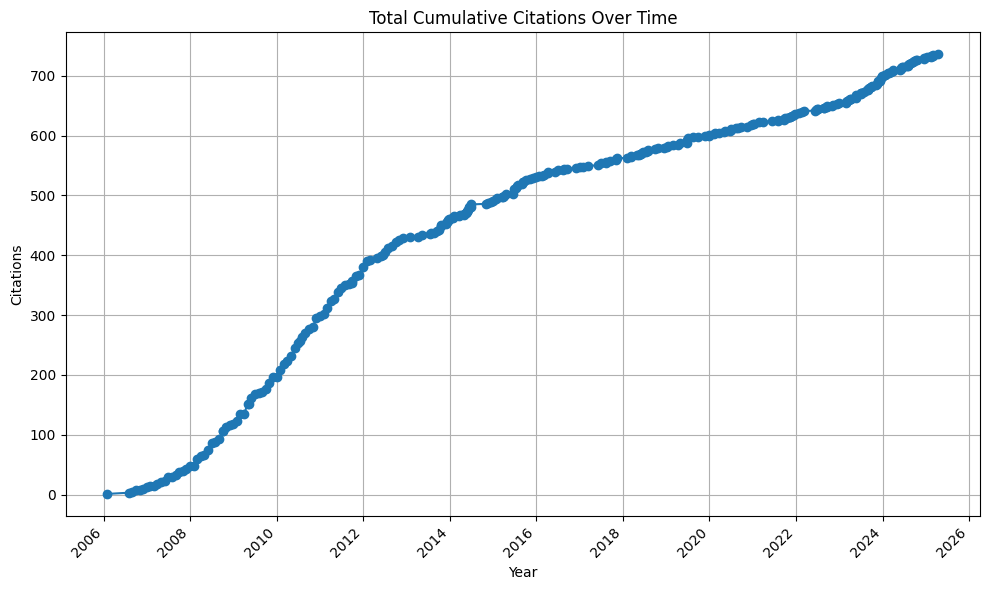

In [10]:
from IPython.display import display
fig = plot_citations(df)

In [11]:
# Save to PDF:
fig.savefig("cumulative_citations.pdf", format="pdf", bbox_inches="tight")